# Process Trim images of CTIO Data
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : November 15th 2016

### This notebook does the calibration
-----------------------------------------
- Subtract Master-bias and correct for Master-flat
- the corrected images are saved

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [19]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Calibration
-------------------

- Read master dark and flats

In [20]:
rootpath_rawcalib='../../CTIOData2016/August2016/Data/'

In [21]:
filenames= ['master_dark_n1.fits','masterflat_gband.fits', 'masterflat_iband.fits', 'masterflat_rband.fits','masterflat_zband.fits']

In [22]:
all_calibfiles = []
for index in np.arange(0,5):
    fullfilename=os.path.join(rootpath_rawcalib,filenames[index])
    all_calibfiles.append(fullfilename)

### Compute Master Dark 

In [23]:
hdu_list=fits.open(all_calibfiles[0])
masterdark_data = hdu_list[0].data
hdu_list.close()

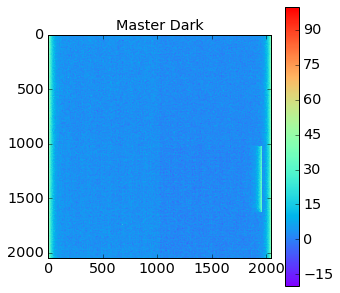

In [24]:
fig = plt.figure(figsize=(5,5))
title='Master Dark';
im=plt.imshow(masterdark_data,cmap='rainbow',vmin=-20,vmax=100)
plt.colorbar(im)
plt.title(title)

### Compute Master-Flat

In [25]:
masterflat_data = []
for index in np.arange(1,5):
    hdu_list=fits.open(all_calibfiles[index])
    masterflat_data.append(hdu_list[0].data)
    hdu_list.close()

In [26]:
avermasterflat_data= (masterflat_data[0]+masterflat_data[1]+masterflat_data[2]+masterflat_data[3])/4.

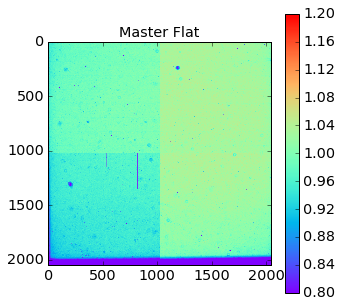

In [27]:
fig = plt.figure(figsize=(5,5))
title='Master Flat';
im=plt.imshow(avermasterflat_data,cmap='rainbow',vmin=0.8,vmax=1.2)
plt.colorbar(im)
plt.title(title)

## Location of trim images
----------------------------------

In [28]:
rootpath_rawimage="../../CTIOData2016/August2016/Trim_HD205905"
object_name='HD205905'

In [29]:
filelist_all=os.listdir(rootpath_rawimage) 

In [30]:
indexes_files= []
filelist_fitsimages= []
for filename in filelist_all:
    if re.search('^trim_fileno.*fits$',filename):  #example of filename filter
        str_number=re.findall('^trim_fileno([0-9]+).fits$',filename)
        number=int(float(str_number[0]))
        filelist_fitsimages.append(filename)
        indexes_files.append(number)

In [31]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [32]:
sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files

In [33]:
sorted_numbers= [indexes_files[index] for index in sorted_indexes]

## Build full filename
----------------------------

In [34]:
sorted_filenames=[]
for file in sorted_files:
    fullfilename=os.path.join(rootpath_rawimage,file)
    indexes_files.append(number)
    sorted_filenames.append(fullfilename)

## Correct images
-------------------------

In [56]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
for idx,file in np.ndenumerate(sorted_filenames):   
    hdu_list=fits.open(file)
    header=hdu_list[0].header
    date_obs = header['DATE-OBS']
    airmass = header['AIRMASS']
    num=sorted_numbers[idx[0]]
    title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
    image_raw=hdu_list[0].data
    image=(image_raw-masterdark_data)/avermasterflat_data
    all_dates.append(date_obs)
    all_airmass.append(float(airmass))
    all_images.append(image)
    all_titles.append(title)
    all_header.append(header)
    hdu_list.close()
    

## Show images
-----------------------

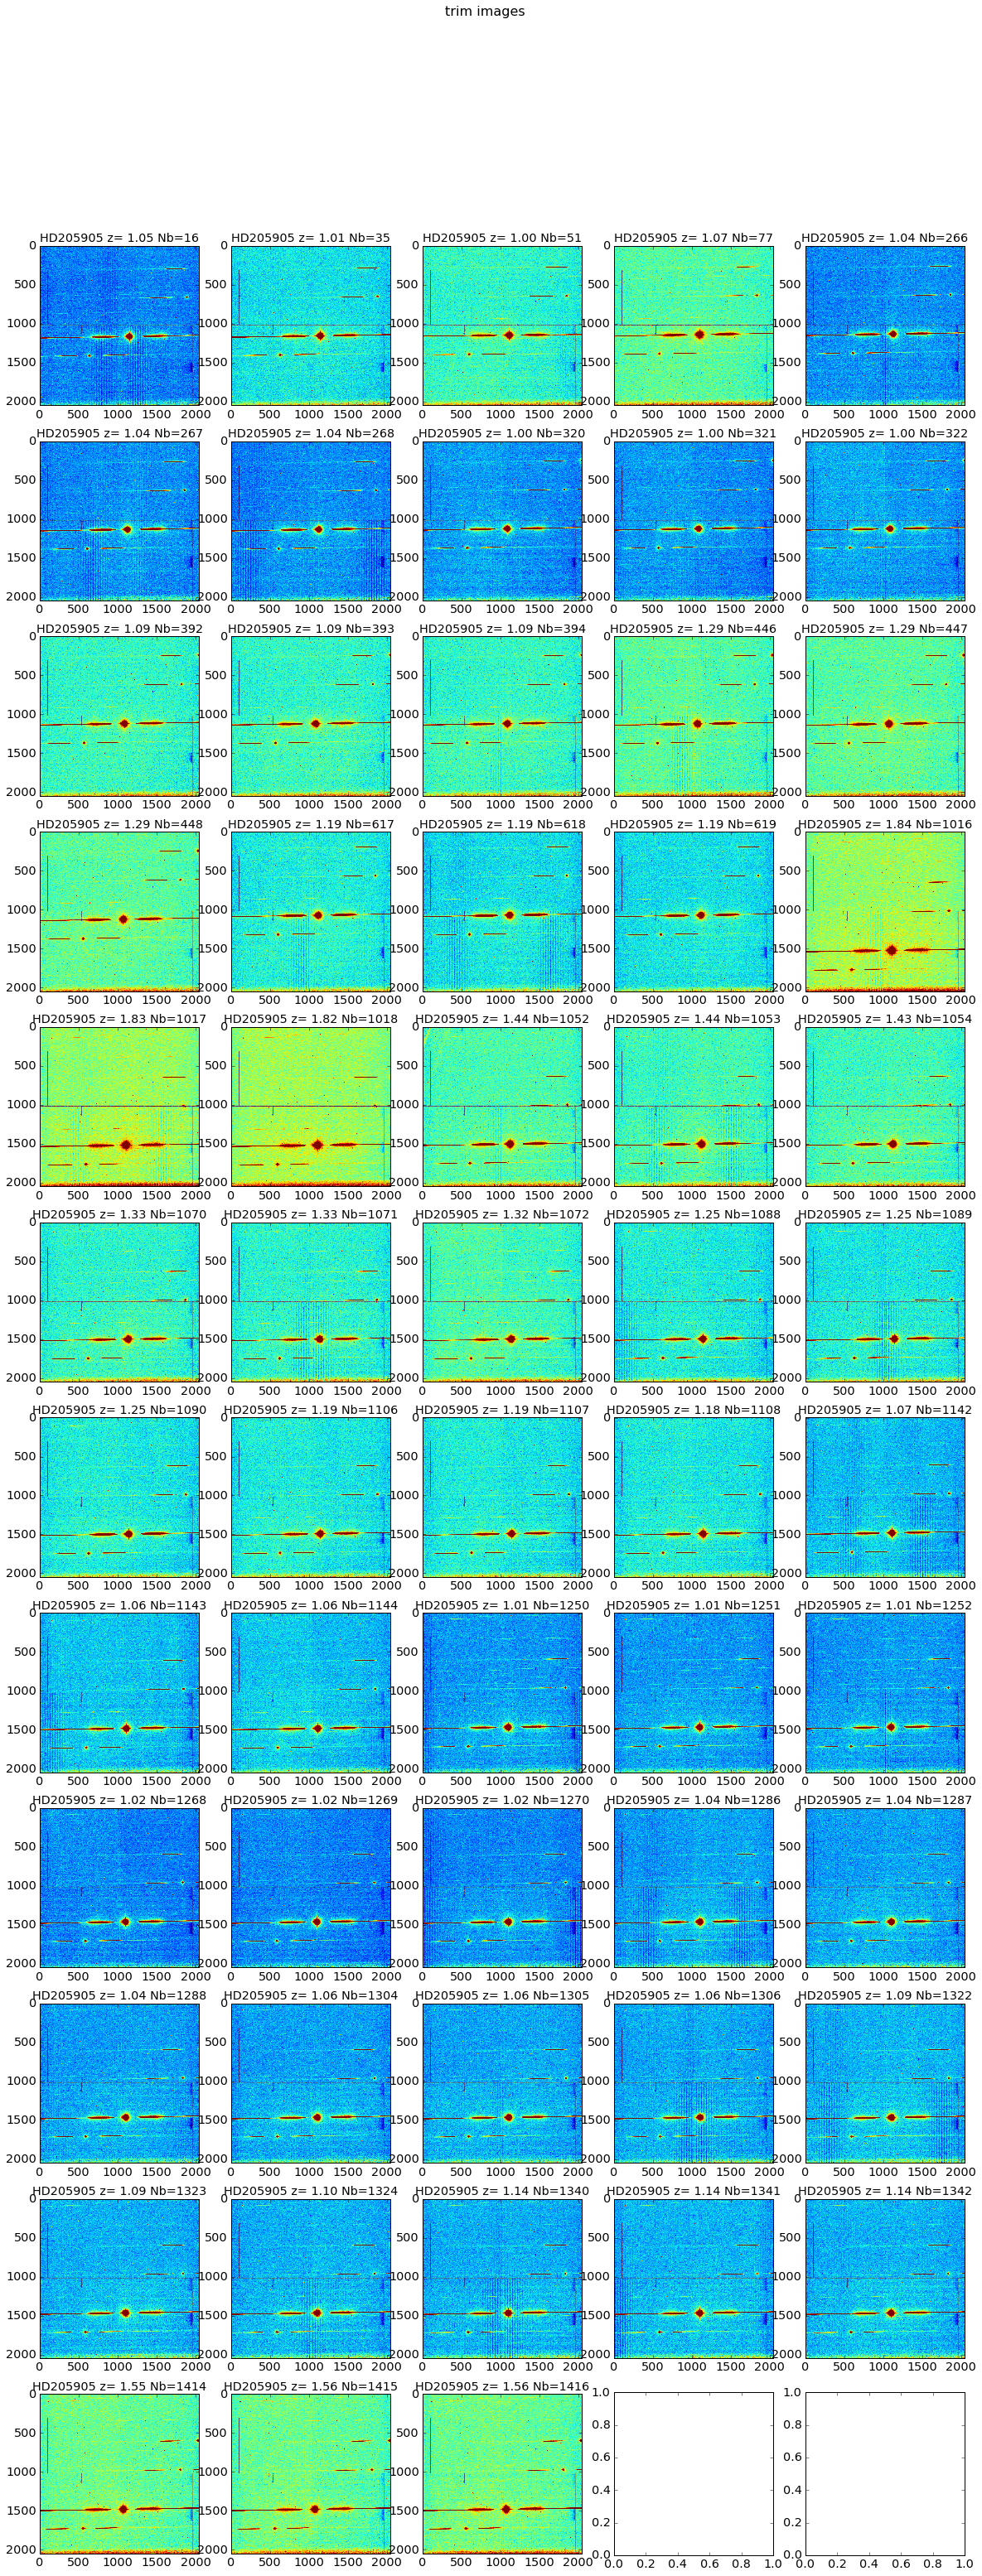

In [39]:
NBIMAGES=len(all_images)
f, axarr = plt.subplots(12,5,figsize=(20,50))
for index in np.arange(0,NBIMAGES):
    ix=index%5
    iy=index/5
    im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=100)
    axarr[iy,ix].set_title(all_titles[index])
title='corrected images'
plt.suptitle(title,size=16)        

## Show histograms
---------------------------

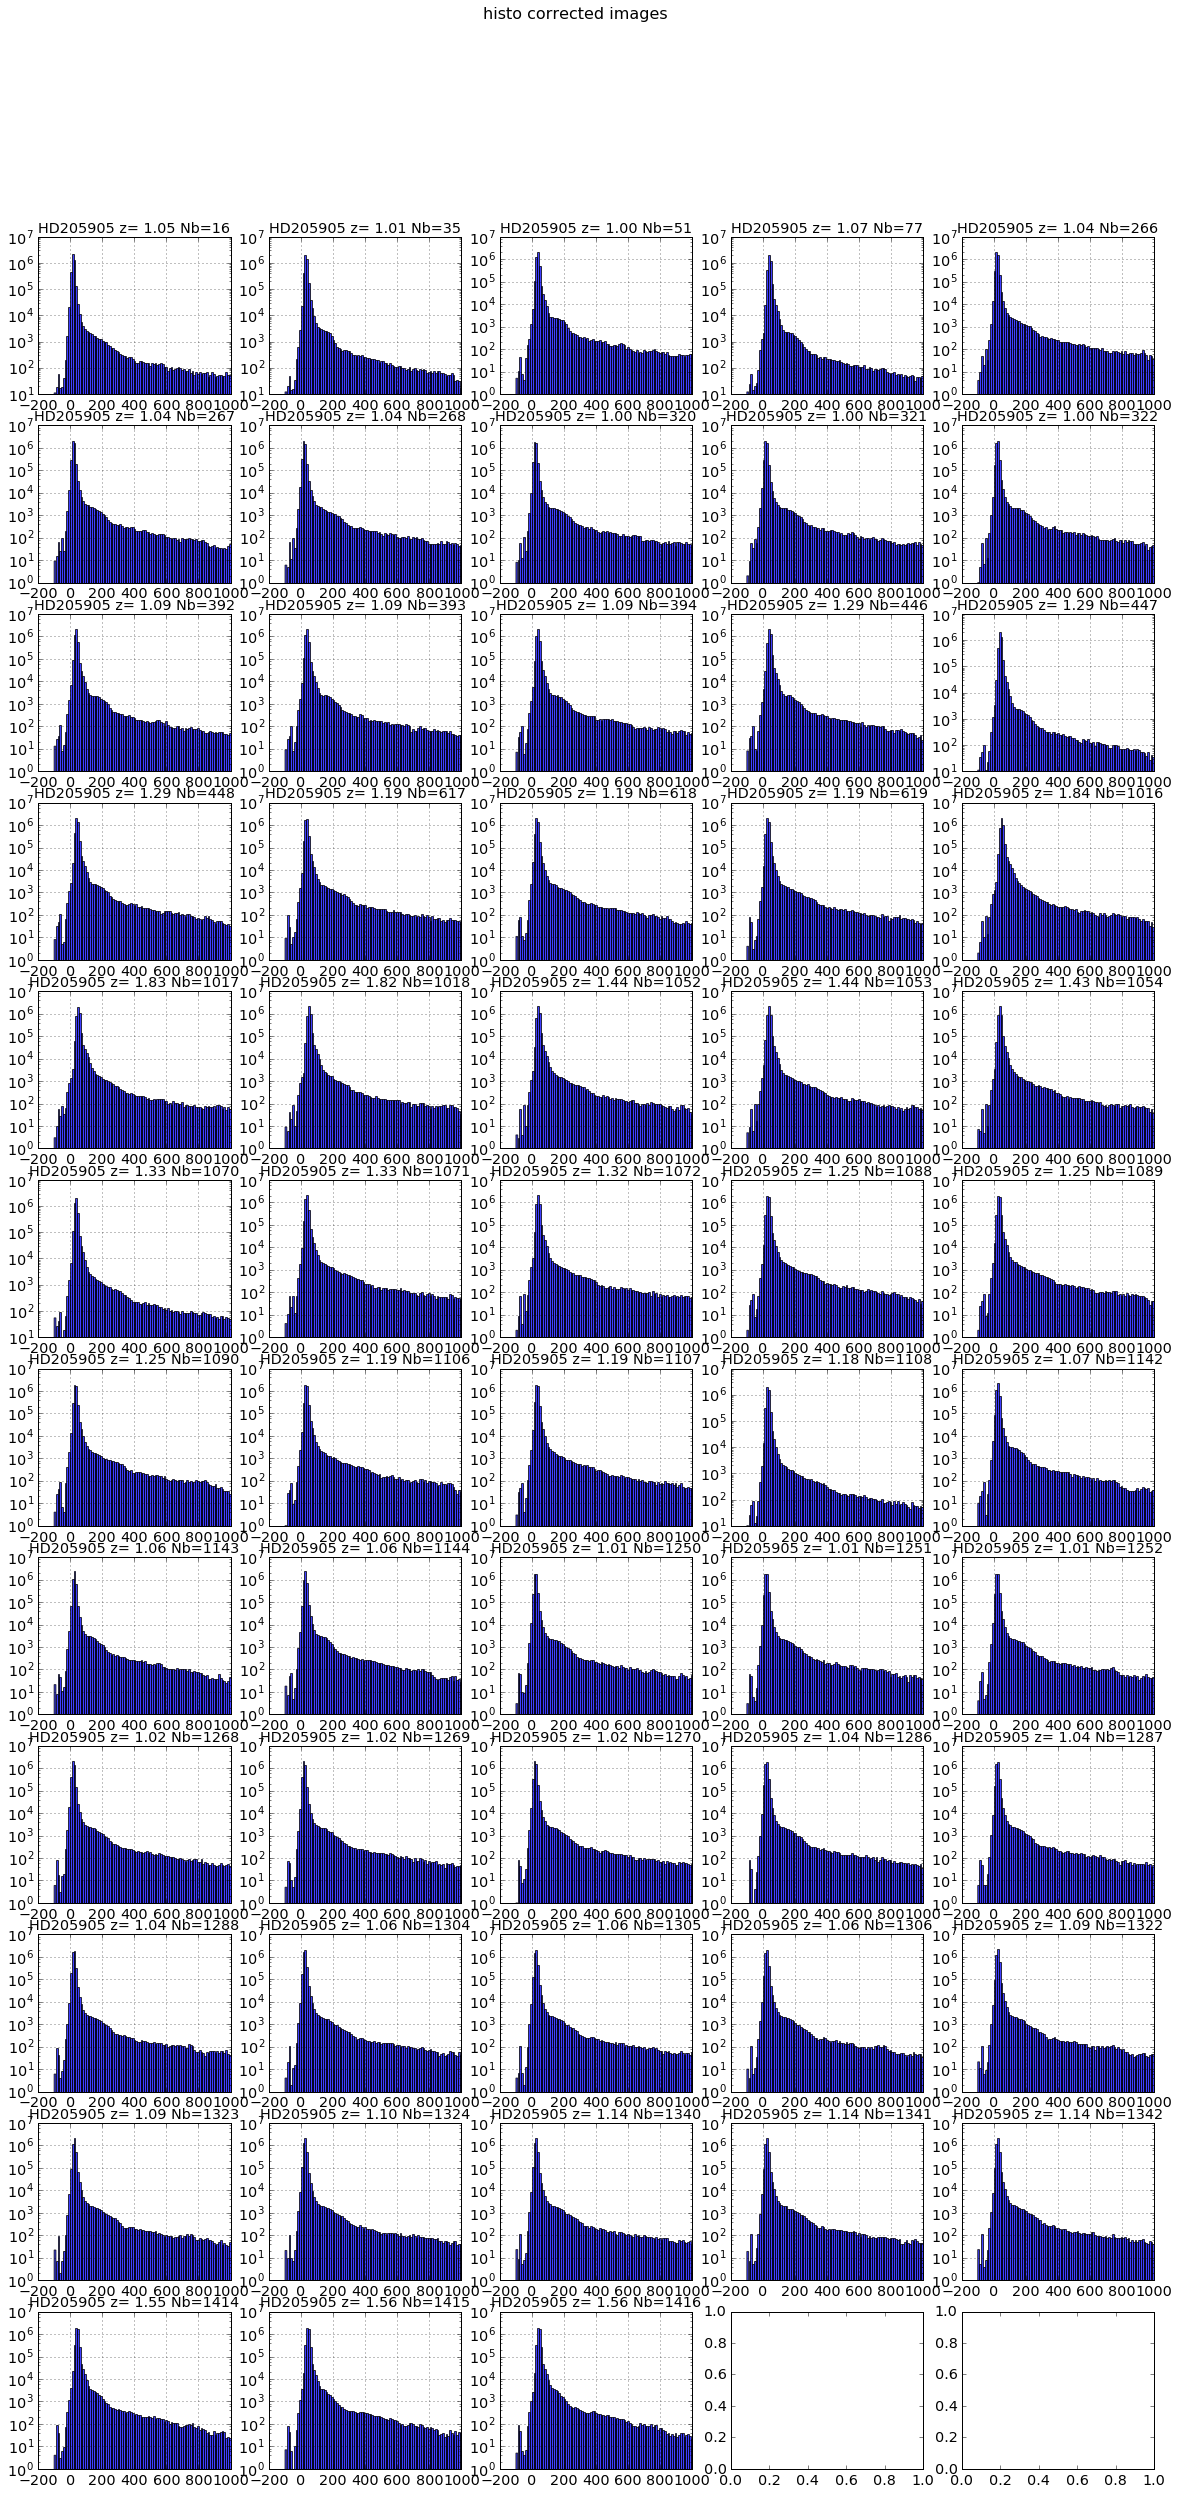

In [49]:
NBIMAGES=len(all_images)
f, axarr = plt.subplots(12,5,figsize=(20,40))
for index in np.arange(0,NBIMAGES):
    ix=index%5
    iy=index/5
    image_flat=all_images[index].flatten()
    stat_mean=image_flat.mean()
    stat_rms=image_flat.std()
    legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
    axarr[iy,ix].hist(image_flat,bins=100,range=(-100,1000),facecolor='blue', alpha=0.75,label=legtitle);
    axarr[iy,ix].set_yscale('log')
    axarr[iy,ix].grid(True)
    axarr[iy,ix].set_title(all_titles[index])
    #axarr[iy,ix].legend(loc='best')  #useless
title='histo corrected images '
plt.suptitle(title,size=16)        

## Build filename for output
------------------------------------

In [54]:
sorted_newfiles=[]
for file in sorted_files:
    trunk=re.findall('^trim_(.*fits$)',file)
    newfile='corr_'+trunk[0]
    sorted_newfiles.append(newfile)

## Save processed file
-------------------------------

In [69]:
for idx,file in np.ndenumerate(sorted_newfiles):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=all_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)